In [5]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.image as mpimg
from keras.preprocessing import image
import datetime
%matplotlib inline

from sklearn.model_selection import train_test_split

In [6]:
#creating empty lists where we will match the class of image with its code ("0" for the closed eye, "1" for the open eye)
X = []
Y = []

for i in tqdm(glob('/kaggle/input/mrl-dataset/train/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((224,224)).convert("RGB"))
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('/kaggle/input/mrl-dataset/train/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((224,224)).convert("RGB"))
    X.append(temp)
    Y.append(0)

100%|██████████| 2000/2000 [00:10<00:00, 195.66it/s]


# Exploratory data analysis

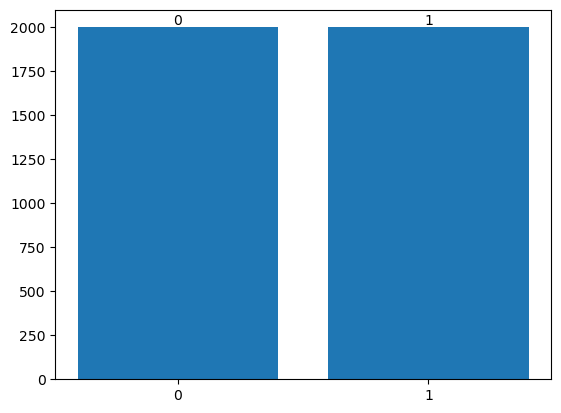

In [7]:
#checking balance of classes
Y_unique = list(set(Y))
counts = [Y.count(value) for value in Y_unique]
barcontainer = plt.bar(range(len(Y_unique)),counts)
plt.bar_label(barcontainer,Y_unique,label_type='edge')
plt.xticks([0,1])
plt.show()

Image dimensions: (86, 86)


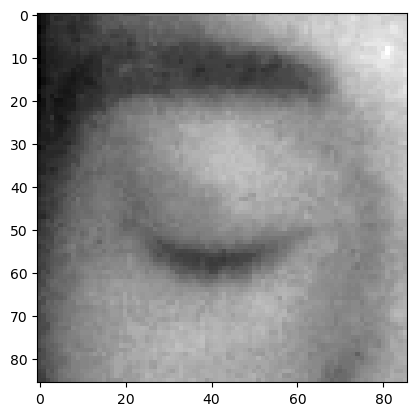

In [8]:
# Read in the image
image = mpimg.imread('/kaggle/input/mrl-dataset/train/Closed_Eyes/s0001_00001_0_0_0_0_0_01.png')

# Print out the image dimensions
print('Image dimensions:', image.shape)
plt.imshow(image, cmap="gray")

The dataset is balanced. It has 2 classes with 2000 images in each of them.

# Building a MobileNet model

In [9]:
X = np.array(X)
X = X/255.0
Y = np.array(Y)

In [10]:
X.shape

(4000, 224, 224, 3)

We will split the dataset into 3 parts: 70% for training the model, 15% - for the model validation and 15% for testing the model.

In [11]:
X_train, X_test1, Y_train, Y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test1, Y_test1, test_size=0.5, random_state=42)

In [12]:
model_mb= tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 1s 0us/step


In [13]:
model_mb.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [14]:
base_input = model_mb.layers[0].input
base_output = model_mb.layers[-4].output

In [15]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)

In [16]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [17]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [18]:
new_model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [19]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3)

In [20]:
chckpntng_pth = "best_checkpoint"
chckpntng = tf.keras.callbacks.ModelCheckpoint(
    filepath = chckpntng_pth,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)

In [22]:
history_ds = new_model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid],  epochs=5, callbacks=[early_stopping, chckpntng])

Epoch 1/5
88/88 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9936
Epoch 1: val_loss improved from inf to 0.07008, saving model to best_checkpoint
88/88 [==============================] - 323s 4s/step - loss: 0.0250 - accuracy: 0.9936 - val_loss: 0.0701 - val_accuracy: 0.9850
Epoch 2/5
88/88 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9968
Epoch 2: val_loss did not improve from 0.07008
88/88 [==============================] - 309s 4s/step - loss: 0.0160 - accuracy: 0.9968 - val_loss: 0.3499 - val_accuracy: 0.8600
Epoch 3/5
88/88 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993
Epoch 3: val_loss improved from 0.07008 to 0.00905, saving model to best_checkpoint
88/88 [==============================] - 319s 4s/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 4/5
88/88 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996
Epoch 4: val_loss improved 

In [23]:
new_model.evaluate(X_test, Y_test)

19/19 [==============================] - 12s 656ms/step - loss: 1.2237e-06 - accuracy: 1.0000


[1.2236828297318425e-06, 1.0]

In [24]:
new_model.save('/kaggle/working/MobileNet_model',save_format = 'tf')